<a href="https://colab.research.google.com/github/GitZy6666/ZyRep/blob/main/Klasifikasi_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
from random import randrange
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [ ]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    
    def __init__(self, n_trees, max_depth,
                 min_samples_split=2, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def randforest_fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def randforest_predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [ ]:
class cross_validaton():
  
  def __init__(self):
    pass

  # Split a dataset into k folds
  def cross_validation_split(self, dataset, folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
      fold = list()
      while len(fold) < fold_size:
        index = randrange(len(dataset_copy))
        fold.append(dataset_copy.pop(index))
      dataset_split.append(fold)
    return dataset_split

  def cross_validation_score(self, estimator, dataset, folds):
    self.estimator = estimator
    self.dataset = dataset
    self.folds = folds

    presisiAF = np.array([])
    npvAF = np.array([])
    spesifisitasAF = np.array([])
    sensitivitasAF = np.array([])
    f1scoreAF = np.array([])
    akurasiAF = np.array([])

    presisiN = np.array([])
    npvN = np.array([])
    spesifisitasN = np.array([])
    sensitivitasN = np.array([])
    f1scoreN = np.array([])
    akurasiN = np.array([])

    presisiPVC = np.array([])
    npvPVC = np.array([])
    spesifisitasPVC = np.array([])
    sensitivitasPVC = np.array([])
    f1scorePVC = np.array([])
    akurasiPVC = np.array([])

    acuracy = np.array([])

    datafold = self.cross_validation_split(self.dataset, self.folds)
    datafold = np.asarray(datafold)

    print("K-Fold Cross-Validation")
    print("Dengan k = "+str(self.folds))
    print(" ")

    dimensi_model = dataset.shape[1]
    for i in range(self.folds):
      dataTest = np.array(datafold[i,:,:])
      dataTrain = np.delete(datafold, i, axis=0)
      dataTrain = np.array(dataTrain)
      dataTrain = dataTrain.reshape(-1, dimensi_model)

      X_train = np.array(dataTrain[:, 0:dimensi_model-1])
      y_train = np.array(dataTrain[:, dimensi_model-1])
      X_test = np.array(dataTest[:, 0:dimensi_model-1])
      y_test = np.array(dataTest[:, dimensi_model-1])
      
      y_train = y_train.astype(np.int64)
      y_test = y_test.astype(np.int64)

      trainWeight = self.estimator.randforest_fit(X_train, y_train)
      predictY = self.estimator.randforest_predict(X_test)
      
      predictY = pd.DataFrame(predictY)
      y_test = pd.DataFrame(y_test)
      predictY = predictY.replace([0,1,2], ['AF','PVC','Normal'])
      y_test = y_test.replace([0,1,2], ['AF','PVC','Normal'])

      score = accuracy_score(y_test, predictY)

      cm = confusion_matrix(y_test, predictY)

      TPA = cm[0,0]
      TNA = cm[1,1]+cm[1,2]+cm[2,1]+cm[2,2]
      FPA = cm[1,0]+cm[2,0]
      FNA = cm[0,1]+cm[0,2]

      TPN = cm[1,1]
      TNN = cm[0,0]+cm[2,0]+cm[0,2]+cm[2,2]
      FPN = cm[1,0]+cm[1,2]
      FNN = cm[1,0]+cm[1,2]

      TPP = cm[2,2]
      TNP = cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
      FPP = cm[0,2]+cm[1,2]
      FNP = cm[2,0]+cm[2,1]

      Presisi_AF = TPA/(TPA+FPA) 
      if math.isnan(Presisi_AF) == True:
         Presisi_AF = 0.00
      Npv_AF = TNA/(TNA+FNA) 
      if math.isnan(Npv_AF) == True:
         Npv_AF = 0.00   
      Spesifisitas_AF = TNA/(TNA+FPA)
      if math.isnan(Spesifisitas_AF) == True:
         Spesifisitas_AF = 0.00
      Sensitivitas_AF =  TPA/(TPA+FNA)
      if math.isnan(Sensitivitas_AF) == True:
         Sensitivitas_AF = 0.00
      F1_Score_AF = 2 * ((Presisi_AF * Sensitivitas_AF)/(Presisi_AF + Sensitivitas_AF))
      if math.isnan(F1_Score_AF) == True:
         F1_Score_AF = 0.00
      Akurasi_AF = (TPA + TNA)/(TPA + FPA + FNA + TNA)
      if math.isnan(Akurasi_AF) == True:
         Akurasi_AF = 0.00

      Presisi_N = TPN/(TPN+FPN)
      if math.isnan(Presisi_N) == True:
         Presisi_N = 0.00
      Npv_N = TNN/(TNN+FNN) 
      if math.isnan(Npv_N) == True:
         Npv_N = 0.00
      Spesifisitas_N = TNN/(TNN+FPN)
      if math.isnan(Spesifisitas_N) == True:
         Spesifisitas_N = 0.00
      Sensitivitas_N =  TPN/(TPN+FNN)
      if math.isnan(Sensitivitas_N) == True:
         Sensitivitas_N = 0.00
      F1_Score_N = 2 * ((Presisi_N * Sensitivitas_N)/(Presisi_N + Sensitivitas_N))
      if math.isnan(F1_Score_N) == True:
         F1_Score_N = 0.00
      Akurasi_N = (TPN + TNN)/(TPN + FPN + FNN + TNN)
      if math.isnan(Akurasi_N) == True:
         Akurasi_N = 0.00

      Presisi_PVC = TPP/(TPP+FPP)
      if math.isnan(Presisi_PVC) == True:
         Presisi_PVC = 0.00
      Npv_PVC = TNP/(TNP+FNP) 
      if math.isnan(Npv_PVC) == True:
         Npv_PVC = 0.00
      Spesifisitas_PVC = TNP/(TNP+FPP)
      if math.isnan(Spesifisitas_PVC) == True:
         Spesifisitas_PVC = 0.00
      Sensitivitas_PVC =  TPP/(TPP+FNP)
      if math.isnan(Sensitivitas_PVC) == True:
         Sensitivitas_PVC = 0.00
      F1_Score_PVC = 2 * ((Presisi_PVC * Sensitivitas_PVC)/(Presisi_PVC + Sensitivitas_PVC))
      if math.isnan(F1_Score_PVC) == True:
         F1_Score_PVC = 0.00
      Akurasi_PVC = (TPP + TNP)/(TPP + FPP + FNP + TNP)
      if math.isnan(Akurasi_PVC) == True:
         Akurasi_PVC = 0.00

      presisiAF = np.append(presisiAF, Presisi_AF)
      presisiN = np.append(presisiN, Presisi_N)
      presisiPVC = np.append(presisiPVC, Presisi_PVC)

      npvAF = np.append(npvAF, Npv_AF)
      npvN = np.append(npvN, Npv_N)
      npvPVC = np.append(npvPVC, Npv_PVC)

      spesifisitasAF = np.append(spesifisitasAF, Spesifisitas_AF)
      spesifisitasN = np.append(spesifisitasN, Spesifisitas_N)
      spesifisitasPVC = np.append(spesifisitasPVC, Spesifisitas_PVC)

      sensitivitasAF = np.append(sensitivitasAF, Sensitivitas_AF)
      sensitivitasN = np.append(sensitivitasN, Sensitivitas_N)
      sensitivitasPVC = np.append(sensitivitasPVC, Sensitivitas_PVC)

      f1scoreAF = np.append(f1scoreAF, F1_Score_AF)
      f1scoreN = np.append(f1scoreN, F1_Score_N)
      f1scorePVC = np.append(f1scorePVC, F1_Score_PVC)

      akurasiAF = np.append(akurasiAF, Akurasi_AF)
      akurasiN = np.append(akurasiN, Akurasi_N)
      akurasiPVC = np.append(akurasiPVC, Akurasi_PVC)

      acuracy = np.append(acuracy, score)

      print("Iterasi Ke-"+str(i+1)+" :")
      print(confusion_matrix(y_test, predictY))
      print(classification_report(y_test, predictY))
      print("Akurasi AF        ", round(Akurasi_AF,2))
      print("Akurasi Normal    ", round(Akurasi_N,2))
      print("Akurasi PVC       ", round(Akurasi_PVC,2))
      print(" ")

    print("K-Fold Cross-Validation")
    print("Dengan k = "+str(self.folds))
    print(" ")
    print("AF")
    print("Presisi      : ", round(presisiAF.mean(),2))
    print("NPV          : ", round(npvAF.mean(),2))
    print("Spesifisitas : ", round(spesifisitasAF.mean(),2))
    print("Sensitivitas : ", round(sensitivitasAF.mean(),2))
    print("F1 Score     : ", round(f1scoreAF.mean(),2))
    print("Akurasi      : ", round(akurasiAF.mean(),2))
    print(" ")
    print("Normal")
    print("Presisi      : ", round(presisiN.mean(),2))
    print("NPV          : ", round(npvN.mean(),2))
    print("Spesifisitas : ", round(spesifisitasN.mean(),2))
    print("Sensitivitas : ", round(sensitivitasN.mean(),2))
    print("F1 Score     : ", round(f1scoreN.mean(),2))
    print("Akurasi      : ", round(akurasiN.mean(),2))
    print(" ")
    print("PVC")
    print("Presisi      : ", round(presisiPVC.mean(),2))
    print("NPV          : ", round(npvPVC.mean(),2))
    print("Spesifisitas : ", round(spesifisitasPVC.mean(),2))
    print("Sensitivitas : ", round(sensitivitasPVC.mean(),2))
    print("F1 Score     : ", round(f1scorePVC.mean(),2))
    print("Akurasi      : ", round(akurasiPVC.mean(),2))
    print(" ")
    print("Acuracy : ",acuracy)
    print("Mean Acuracy : ", acuracy.mean())  

In [ ]:
data = pd.read_csv('datasetFx1.csv')

In [ ]:
dataset = data[['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate','label']]
dataset.head(n=5)

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,label
0,95.275428,629.753143,171.525577,90.483643,185.627225,0.909091,0.818182,115.79875,131.194012,173.100312,71344.703043,0.757907,0.113507,AF
1,97.193733,617.323750,181.249188,138.833634,286.355128,1.000000,0.800000,185.66700,202.402918,167.298639,106379.770624,1.209830,0.405310,AF
2,101.888446,588.879331,141.673136,100.503504,186.636554,0.888889,0.888889,123.67870,131.684965,148.097312,61267.934473,0.889179,0.261540,AF
3,94.900146,632.243493,188.842372,72.566311,230.568362,1.000000,1.000000,172.41520,163.026168,179.154506,91756.096111,0.909975,0.211104,AF
4,98.921133,606.543800,163.855814,96.144362,213.936146,1.000000,0.909091,128.83360,144.742605,176.601372,80304.582543,0.819601,0.549934,AF


In [ ]:
df_norm = dataset[['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_norm[:5]

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,0.537053,0.301240,0.903337,0.598420,0.627803,0.888430,0.818182,0.608978,0.627733,0.643089,0.639680,0.196169,0.076870
1,0.568010,0.275548,0.957614,0.948015,1.000000,1.000000,0.800000,1.000000,1.000000,0.620569,0.955017,0.396073,0.433511
2,0.643771,0.216754,0.736698,0.670869,0.631532,0.863636,0.888889,0.653079,0.630300,0.546036,0.548983,0.254236,0.257796
3,0.530997,0.306387,1.000000,0.468869,0.793864,1.000000,1.000000,0.925835,0.794146,0.666590,0.823395,0.263435,0.196153
4,0.595886,0.253266,0.860524,0.639350,0.732406,1.000000,0.909091,0.681928,0.698563,0.656679,0.720324,0.223459,0.610270


In [ ]:
# men-scaling dataset
scale_X = StandardScaler()
df_norm = scale_X.fit_transform(df_norm)
df_norm[:5]

array([[ 0.66277691, -0.74771806,  1.78288265,  0.52789095,  0.88250674,
         0.6030894 ,  0.77130172,  1.40386   ,  0.89894502,  1.67210104,
         1.59861944, -0.74798778, -0.96347763],
       [ 0.81307598, -0.87018987,  2.01140695,  2.06992312,  2.44188551,
         0.99440722,  0.71553431,  3.1992105 ,  2.46102304,  1.55314631,
         2.99207042,  0.37838397,  0.63279664],
       [ 1.18090627, -1.15046417,  1.08129058,  0.8474556 ,  0.89813226,
         0.51612989,  0.98817496,  1.60634499,  0.90971483,  1.15945144,
         1.19783577, -0.42080748, -0.15367757],
       [ 0.63337366, -0.72317963,  2.18986196, -0.04354872,  1.578245  ,
         0.99440722,  1.32897577,  2.85868922,  1.59723283,  1.79623336,
         2.4104425 , -0.36897397, -0.42958479],
       [ 0.94841758, -0.97640905,  1.60262788,  0.70842893,  1.32075999,
         0.99440722,  1.05013874,  1.73880648,  1.19615446,  1.74388511,
         1.95498105, -0.59422353,  1.42395006]])

Text(0, 0.5, 'Cumulative explained variance')

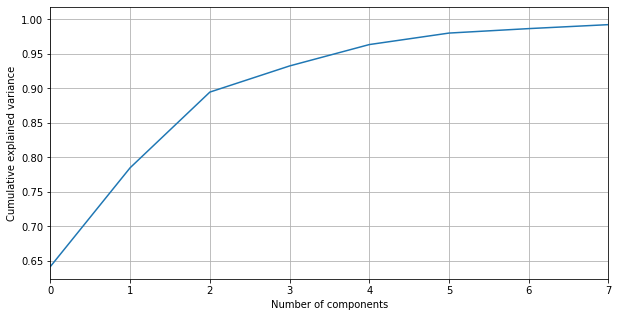

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA()
pca.fit(df_norm)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.grid(True,which='both')
plt.plot(exp_var_cumul)
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
pecea_data = PCA(n_components=5)
pecea_data.fit(df_norm)
pecea_dataframeX = pecea_data.transform(df_norm)
pecea_dataframeX[:5]

array([[ 3.41610112, -1.80208262,  0.43596966, -0.12964502, -0.15104888],
       [ 6.26491637, -0.51565516, -1.05344895,  0.89532419,  0.50941535],
       [ 3.38502541, -0.60057443,  0.82787488,  0.09891563,  0.03172858],
       [ 4.93167947, -1.58245733, -0.1451943 ,  0.24982527, -1.25501166],
       [ 4.4094424 , -0.21615222,  0.37295527,  1.53836128, -0.4515174 ]])

In [ ]:
df_norm_pca = pd.DataFrame(pecea_dataframeX)
df_norm_pca[:5]

,0,1,2,3,4
0,3.416101,-1.802083,0.435970,-0.129645,-0.151049
1,6.264916,-0.515655,-1.053449,0.895324,0.509415
2,3.385025,-0.600574,0.827875,0.098916,0.031729
3,4.931679,-1.582457,-0.145194,0.249825,-1.255012
4,4.409442,-0.216152,0.372955,1.538361,-0.451517


In [ ]:
diagnosa = data[['label']].replace(['AF','PVC','Normal'],[0,1,2])
diagnosa[:5]

,label
0,0
1,0
2,0
3,0
4,0


In [ ]:
df = pd.concat([df_norm_pca, diagnosa], axis=1)
df[:5]

,0,1,2,3,4,label
0,3.416101,-1.802083,0.435970,-0.129645,-0.151049,0
1,6.264916,-0.515655,-1.053449,0.895324,0.509415,0
2,3.385025,-0.600574,0.827875,0.098916,0.031729,0
3,4.931679,-1.582457,-0.145194,0.249825,-1.255012,0
4,4.409442,-0.216152,0.372955,1.538361,-0.451517,0


In [ ]:
df_arr = np.array(df)
df_arr[:5]

array([[ 3.41610112, -1.80208262,  0.43596966, -0.12964502, -0.15104888,
         0.        ],
       [ 6.26491637, -0.51565516, -1.05344895,  0.89532419,  0.50941535,
         0.        ],
       [ 3.38502541, -0.60057443,  0.82787488,  0.09891563,  0.03172858,
         0.        ],
       [ 4.93167947, -1.58245733, -0.1451943 ,  0.24982527, -1.25501166,
         0.        ],
       [ 4.4094424 , -0.21615222,  0.37295527,  1.53836128, -0.4515174 ,
         0.        ]])

In [ ]:
RFClassifier = RandomForest(n_trees=10, max_depth=3)

In [ ]:
kfoldCV = cross_validaton()

In [ ]:
kfoldCV.cross_validation_score(RFClassifier, dataset=df_arr, folds=5)

K-Fold Cross-Validation
Dengan k = 5
 
Iterasi Ke-1 :
[[12  0  1]
 [ 0  6  0]
 [ 1  0  7]]
              precision    recall  f1-score   support

          AF       0.92      0.92      0.92        13
      Normal       1.00      1.00      1.00         6
         PVC       0.88      0.88      0.88         8

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.93      0.93      0.93        27

Akurasi AF         0.93
Akurasi Normal     1.0
Akurasi PVC        0.93
 
Iterasi Ke-2 :
[[ 9  0  0]
 [ 1 12  0]
 [ 0  1  4]]
              precision    recall  f1-score   support

          AF       0.90      1.00      0.95         9
      Normal       0.92      0.92      0.92        13
         PVC       1.00      0.80      0.89         5

    accuracy                           0.93        27
   macro avg       0.94      0.91      0.92        27
weighted avg       0.93      0.93      0.92        27

Akurasi AF         0.9